### Retailer Sales Data Forecasting

This dataset contains the daily sales data of a US retailer.  
Your objective is to forecast the total sales for each State over the next 12 months, using the historical data provided.


### Part 1: Top-Down Approach

1. **Aggregate Sales:**  
   Combine the sales data to create total sales at the `year-month` level, using the `Order Date` as the time variable for aggregation.


2. **Train a Model:**  
   Using the aggregated `year-month` data, train a model to forecast the total sales for the next 12 months.  
   *(The choice of model is up to you.)*

3. **Disaggregate Predictions:**  
   Split the predicted sales from the `year-month` level back to the `year-month-State` level.  
   *(The splitting strategy is up to you.)*

4. **Evaluate Accuracy:**  
   Assess the forecast accuracy at both the `year-month` and `year-month-State` levels.


# ____________________________________________________________

### Part 2: Alternative Approach

- Implement a different approach to forecast the next 12 months of sales at the `year-month-State` level.


# ____________________________________________________________

In [45]:
# Libraries

# Data handling and manipulation
import pandas as pd  
import numpy as np  
import os

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Data visualization
import matplotlib.pyplot as plt  

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler  # this scales data between a min and max value

# Deep learning framework
# Time series modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX   
from keras.optimizers import Adam
import visualkeras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping



# ETL

In [46]:
# Load the dataset
df = pd.read_csv('Retailer Sales Data.csv')

# Convert 'Order Date' and 'Ship Date' columns to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')


In [47]:
# Print the number of missing values where both 'Ship Date' and 'Order Date' are missing
print("Number of missing values on 'Ship Date' and 'Order Date':", 
      df[df['Ship Date'].isnull() & df['Order Date'].isnull()].shape[0])

# Calculate shipping days as the difference between 'Ship Date' and 'Order Date'
df['Shipping_days'] = df['Ship Date'] - df['Order Date']

# Calculate the average shipping days
avg_shipping_days = df['Shipping_days'].mean()

# Impute missing 'Order Date' by subtracting the average shipping days from 'Ship Date'
df.loc[df['Order Date'].isnull(), 'Order Date'] = df['Ship Date'] - pd.to_timedelta(avg_shipping_days, unit='D')

# Drop rows where 'Order Date' is still missing
df = df[df['Order Date'].notna()]

# Create a new column 'Year-Month' for the order date at a monthly granularity
df['Year-Month'] = df['Order Date'].dt.to_period('M')

# Identify and print missing months in the dataset
missing_months = pd.period_range(start=df['Year-Month'].min(), 
                                 end=df['Year-Month'].max(), 
                                 freq='M').difference(df['Year-Month'])
print("Missing months of sales:", missing_months)

# Clean up by removing the temporary variable
del avg_shipping_days


Number of missing values on 'Ship Date' and 'Order Date': 14
Missing months of sales: PeriodIndex([], dtype='period[M]')


In [48]:
# Print number of rows with missing 'Sales' and 'Sub-Category'
print("Number of missing values on 'Sales' and 'Sub-Category':", 
      df[['Sales', 'Sub-Category']].isnull().all(axis=1).sum())

# Calculate average sales by 'Sub-Category' and 'Category'
avg_sales_sub_cat = df.groupby('Sub-Category')['Sales'].mean()
avg_sales_cat = df.groupby('Category')['Sales'].mean()

# Impute missing 'Sales' with average sales by 'Sub-Category' and 'Category'
df['Sales'] = df['Sales'].fillna(df['Sub-Category'].map(avg_sales_sub_cat))
df['Sales'] = df['Sales'].fillna(df['Category'].map(avg_sales_cat))

# Drop rows with still missing 'Sales'
df.dropna(subset=['Sales'], inplace=True)

# Clean up
del avg_sales_cat


Number of missing values on 'Sales' and 'Sub-Category': 23


In [49]:
# Check if any 'Customer ID' has more than one 'Customer Name'
print((df.groupby('Customer ID')['Customer Name'].nunique() > 1).sum())

# Create a dictionary to map 'Customer ID' to the first non-null 'State'
state_fill_dict = df.dropna(subset=['State']).groupby('Customer ID')['State'].first().to_dict()

# Fill missing 'State' values based on 'Customer ID'
df['State'] = df['State'].fillna(df['Customer ID'].map(state_fill_dict))

# Create a dictionary to map 'Country' to the first non-null 'State'
city_fill_dict = df.dropna(subset=['State', 'Country']).groupby('Country')['State'].first().to_dict()

# Fill remaining missing 'State' values based on 'Country'
df.loc[df['State'].isna() & df['Country'].notna(), 'State'] = df['Country'].map(city_fill_dict)

# Drop rows where 'State' is still missing
df.dropna(subset=['State'], inplace=True)

# Check for any remaining missing values in 'State'
print(df['State'].isna().sum())

# Clean up
del city_fill_dict
del state_fill_dict


0
0


In [50]:
print(df['Sub-Category'].isna().sum())
# Create a dictionary to map 'Customer ID' to the first non-null 'State'
sub_cat_fill_dict = df.dropna(subset=['Sub-Category']).groupby('Product Name')['Sub-Category'].first().to_dict()
product_id_fill_dict = df.dropna(subset=['Sub-Category']).groupby('Product ID')['Sub-Category'].first().to_dict()

# Fill missing 'State' values based on 'Customer ID'
df['Sub-Category'] = df['Sub-Category'].fillna(df['Product Name'].map(sub_cat_fill_dict))
df['Sub-Category'] = df['Sub-Category'].fillna(df['Product ID'].map(product_id_fill_dict))


print(df['Sub-Category'].isna().sum())
df.dropna(subset=['Sub-Category'], inplace=True)
print(df['Sub-Category'].isna().sum())


481
11
0


# ____________________________________________________________

# Modeling - Top Down Approach (Part 1)

### SARIMA


##### Year - Month Level

In [51]:
# Group sales data by 'Year-Month' and 'State', then sum the sales
monthly_sales_state = df.groupby(['Year-Month', 'State'])['Sales'].sum().reset_index()

# Aggregate sales by 'Year-Month'
monthly_sales = monthly_sales_state.groupby(['Year-Month'])['Sales'].sum()

# Pivot the sales data to get sales by 'State' in columns
sales_by_state = monthly_sales_state.groupby(['Year-Month', 'State'])['Sales'].sum().unstack().fillna(0)

# Calculate the proportion of sales by state for each month
state_proportions = sales_by_state.div(sales_by_state.sum(axis=1), axis=0)

# Split the data into training and test sets based on date
train_data = monthly_sales[monthly_sales.index < '2018-01']
test_data = monthly_sales[monthly_sales.index >= '2018-01']



In [55]:

# Define SARIMA model parameters
p, d, q = 7, 1, 1  # ARIMA parameters
P, D, Q, s = 1, 1, 1, 12  # Seasonal parameters (s=12 for monthly data)

# Train the SARIMA model
model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)


/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#####  Model Evaluation at Year - Month Level

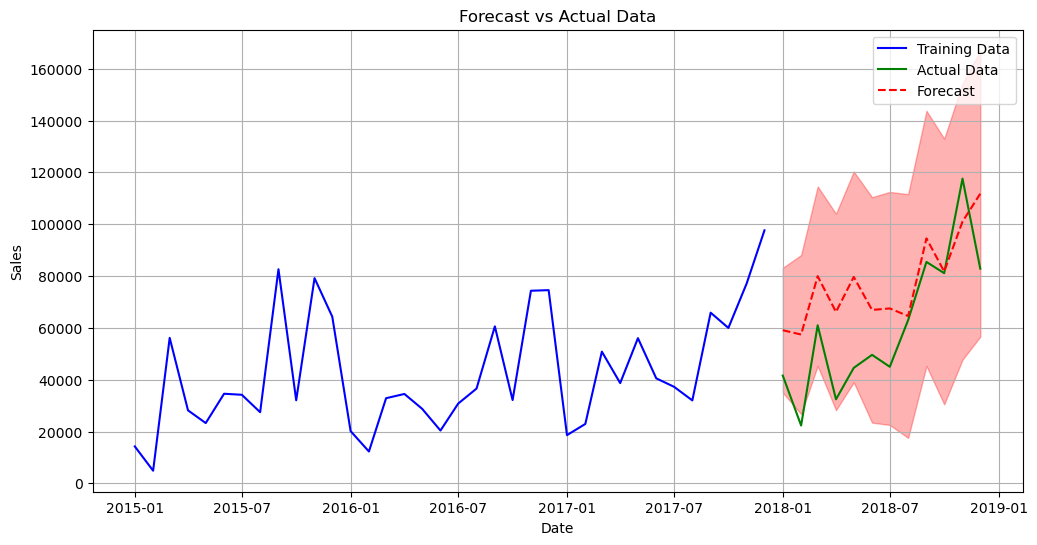

In [56]:
# Make forecasts for the next 12 periods
forecast = model_fit.get_forecast(steps=12)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Create a Series for forecasted values
forecast_index = pd.period_range(start='2018-01', periods=12, freq='M')
forecast_series = pd.Series(forecast_values, index=forecast_index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index.to_timestamp(), train_data, label='Training Data', color='blue')
plt.plot(test_data.index.to_timestamp(), test_data, label='Actual Data', color='green')
plt.plot(forecast_series.index.to_timestamp(), forecast_series, label='Forecast', color='red', linestyle='--')
plt.fill_between(forecast_series.index.to_timestamp(), 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='red', alpha=0.3)
plt.title('Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [57]:

# Evaluate forecast accuracy using MSE, RMSE, and MAE
mse = mean_squared_error(test_data, forecast_series)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast_series)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Squared Error (MSE): 522480488.32
Root Mean Squared Error (RMSE): 22857.83
Mean Absolute Error (MAE): 19751.55


##### Year - Month proportioned by States

In [58]:

# Create a DataFrame to hold proportionally forecasted values for each state
forecast_proportioned = pd.DataFrame(index=forecast_series.index, columns=state_proportions.columns)

# Allocate the total forecasted values proportionally across states
for state in state_proportions.columns:
    forecast_proportioned[state] = forecast_series * state_proportions[state]


In [59]:
test_data_state = pd.DataFrame(index=test_data.index, columns=state_proportions.columns)


#####  Model Results at Year - Month  - states Level

In [60]:
# Ensure the index of forecast_proportioned is in PeriodIndex format and convert if necessary
if isinstance(forecast_proportioned.index, pd.PeriodIndex):
    # Convert PeriodIndex to Timestamp for output
    forecast_proportioned.index = forecast_proportioned.index.to_timestamp()
else:
    # Convert non-periodic index to PeriodIndex first, then to Timestamp
    forecast_proportioned.index = pd.to_datetime(forecast_proportioned.index).to_period('M').to_timestamp()

# Reset index to long format for pivoting
forecast_long = forecast_proportioned.reset_index()

# Convert the DataFrame to long format (pivot)
forecast_long = pd.melt(forecast_long, id_vars=['index'], var_name='State', value_name='Sales')

# Rename 'index' column to 'Year-Month'
forecast_long.rename(columns={'index': 'Year-Month'}, inplace=True)

# Ensure 'Year-Month' is in datetime format
forecast_long['Year-Month'] = pd.to_datetime(forecast_long['Year-Month'], format='%Y-%m')


In [61]:
# Aggregate actual sales data
actualsales = df.groupby(['Year-Month', 'State'])['Sales'].sum().reset_index()

# Convert 'Year-Month' tao PeriodIndex for merging
forecast_long['Year-Month'] = forecast_long['Year-Month'].dt.to_period('M')

# Rename columns for clarity
forecast_long.rename(columns={'Sales': 'Sales_Prediction'}, inplace=True)
actualsales.rename(columns={'Sales': 'Sales_Actual'}, inplace=True)

# Merge forecasted and actual sales data
prediction_and_actuals = forecast_long.merge(actualsales, on=['Year-Month', 'State'], how='left')

# Replace NaN values in 'Sales_Actual' with 0
prediction_and_actuals['Sales_Actual'] = prediction_and_actuals['Sales_Actual'].fillna(0)


In [ ]:

if pd.api.types.is_period_dtype(prediction_and_actuals['Year-Month']):
    prediction_and_actuals['Year-Month'] = prediction_and_actuals['Year-Month'].dt.to_timestamp()
else:
    prediction_and_actuals['Year-Month'] = pd.to_datetime(prediction_and_actuals['Year-Month'], format='%Y-%m')

# Create a directory to save figures
output_dir = 'sarima_state_sales_figures'
os.makedirs(output_dir, exist_ok=True)

# Get the list of unique states
states = prediction_and_actuals['State'].unique()

# Generate and save a plot for each state
for state in states:
    # Filter data for the current state
    state_data = prediction_and_actuals[prediction_and_actuals['State'] == state]
    
    # Set 'Year-Month' as the index
    state_data.set_index('Year-Month', inplace=True)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(state_data.index, state_data['Sales_Prediction'], label='Sales Prediction', marker='o')
    plt.plot(state_data.index, state_data['Sales_Actual'], label='Sales Actual', marker='o')
    plt.title(f'Sales Prediction vs Actual Sales for {state}')
    plt.xlabel('Year-Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot to the specified directory
    file_path = os.path.join(output_dir, f'{state}_sales.png')
    plt.savefig(file_path)
    plt.close()  # Close the figure to free up memory

print(f'Figures saved in the directory: {output_dir}')


# Modeling - Bottom-Up Approach (Part 2)

In [63]:

# Aggregate sales by Year-Month, State, and Sub-Category
df_encoded = df.groupby(['Year-Month', 'State', 'Sub-Category'])['Sales'].sum().reset_index()

#* ######## One-hot encode ############
df_encoded = pd.get_dummies(df_encoded, columns=['Sub-Category', 'State'], drop_first=True)
#* ######## ###############  ##########

# Set 'Year-Month' as index
df_encoded.set_index('Year-Month', inplace=True)

# 3. Extract columns for scaling
features_to_scale = df_encoded[['Sales']]

# Very impotart -   MinMaxScaler to 0 to 1 range - avoiding high values
sales = features_to_scale.values.reshape(-1, 1)
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(sales)

# Convert scaled data back to DataFrame
scaled_df = pd.DataFrame(sales_scaled, columns=['Sales'], index=df_encoded.index)

# Add encoded columns (dummies) to the scaled DataFrame
scaled_df = pd.concat([scaled_df, df_encoded.drop(['Sales'], axis=1)], axis=1)


In [64]:

#* ######## Create training, validation, and test sets ######### 
# Training set up to 01 2017
train_data = scaled_df[scaled_df.index < '2017-01']

# Validation set from 01 2017 to 12 2017
val_data = scaled_df[(scaled_df.index >= '2017-01') & (scaled_df.index <= '2017-12')]

# Test set for 2018
test_data = scaled_df[scaled_df.index >= '2018-01']

##################################
y_train = train_data['Sales'].values
y_val = val_data['Sales'].values
y_test = test_data['Sales'].values  
##################################

##################################
X_train = train_data.drop(['Sales'], axis=1).values
X_val = val_data.drop(['Sales'], axis=1).values
X_test = test_data.drop(['Sales'], axis=1).values  # Test set
##################################

################################## (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Reshape test set
##################################

##################################
# y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
##################################

In [18]:
print(min(y_val), min(y_test), min(y_train))
print(max(y_val), max(y_test), max(y_train))

0.0 3.069191861321636e-05 6.820426358492557e-07
0.7459463648491595 0.5967499645337829 1.0


In [19]:
"""
#* ####################################################
#* ############ Create the LSTM model ################
model = Sequential()  
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 

model.add(Dropout(0.2)) 
model.add(LSTM(units=100, return_sequences=False))  # do not return sequences as it's the last LSTM layer

model.add(Dropout(0.3))  # Add another dropout layer
model.add(Dense(units=1))  # Add a Dense layer with 1 unit for output
#* ####################################################
#* ####################################################

#* ####################################################
#* ############ Create the LSTM model ################
model = Sequential()  
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Dropout(0.2)) 

model.add(LSTM(units=100, return_sequences=True)) 
model.add(Dropout(0.2)) 

model.add(LSTM(units=100, return_sequences=False))  # ultimo LSTM
model.add(Dropout(0.3)) 

model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.3))  # ulteriore Dropout

model.add(Dense(units=1))   # output finale

#* ####################################################
#* ####################################################

# Learning rate for the optimizer
learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate) 


#* ################ Compile and train the model ################
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])  

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))  
"""

"\n#* ####################################################\n#* ############ Create the LSTM model ################\nmodel = Sequential()  \nmodel.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) \n\nmodel.add(Dropout(0.2)) \nmodel.add(LSTM(units=100, return_sequences=False))  # do not return sequences as it's the last LSTM layer\n\nmodel.add(Dropout(0.3))  # Add another dropout layer\nmodel.add(Dense(units=1))  # Add a Dense layer with 1 unit for output\n#* ####################################################\n#* ####################################################\n\n#* ####################################################\n#* ############ Create the LSTM model ################\nmodel = Sequential()  \nmodel.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) \nmodel.add(Dropout(0.2)) \n\nmodel.add(LSTM(units=100, return_sequences=True)) \nmodel.add(Dropout(0.2)) \n\nmodel.add(LSTM(units=100, return_

In [20]:


model = Sequential()

# Primo layer LSTM
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Dropout(0.2)) 
model.add(BatchNormalization())

# Secondo layer LSTM
from keras.regularizers import l2

# Add L2 regularization to LSTM layers
model.add(LSTM(units=100, return_sequences=True, kernel_regularizer='l2'))  #l2(0.01)
model.add(Dropout(0.4)) 
model.add(BatchNormalization())

# Ultimo layer LSTM
model.add(LSTM(units=50, return_sequences=False))  
model.add(Dropout(0.3)) 

# Layer Dense
model.add(Dense(units=50, kernel_regularizer='l2'))  # Aggiungi regolarizzazione L2
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))  # Ulteriore Dropout

# Output layer
model.add(Dense(units=1)) 

# Compila il modello
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=['mae'] )

# Aggiungi Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Addestra il modello
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=2, batch_size=32, callbacks=[early_stopping])


2024-09-29 21:10:45.382803: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-29 21:10:45.382871: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-29 21:10:45.382883: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-29 21:10:45.383500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-29 21:10:45.383828: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/2


2024-09-29 21:10:47.319417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:47.707621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:47.835631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:47.940799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:48.169027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:48.368639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/78 [>.............................] - ETA: 2s - loss: 2.1498 - mae: 0.1992  

2024-09-29 21:10:48.553579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 1.9786 - mae: 0.1495

2024-09-29 21:10:51.111982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:51.232105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:51.305471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:51.365966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 6s 44ms/step - loss: 1.9786 - mae: 0.1495 - val_loss: 1.7980 - val_mae: 0.0215
Epoch 2/2
78/78 [==============================] - 2s 29ms/step - loss: 1.6918 - mae: 0.1217 - val_loss: 1.5433 - val_mae: 0.0226


In [21]:
test_loss, test_mae = model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')


47/47 [==============================] - 1s 13ms/step - loss: 1.5433 - mae: 0.0226
Test Loss: 1.5433193445205688
Test MAE: 0.02260316163301468


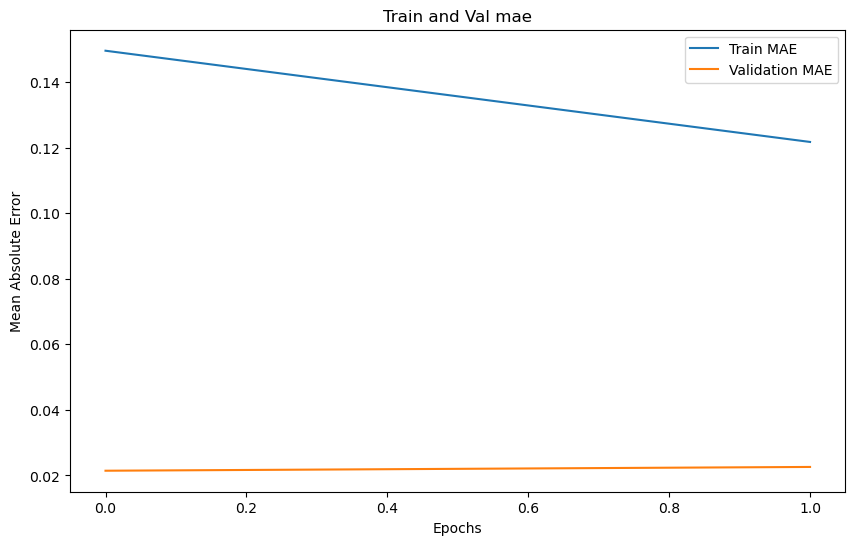

In [22]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')  
plt.plot(history.history['val_mae'], label='Validation MAE')  
plt.title('Train and Val mae')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


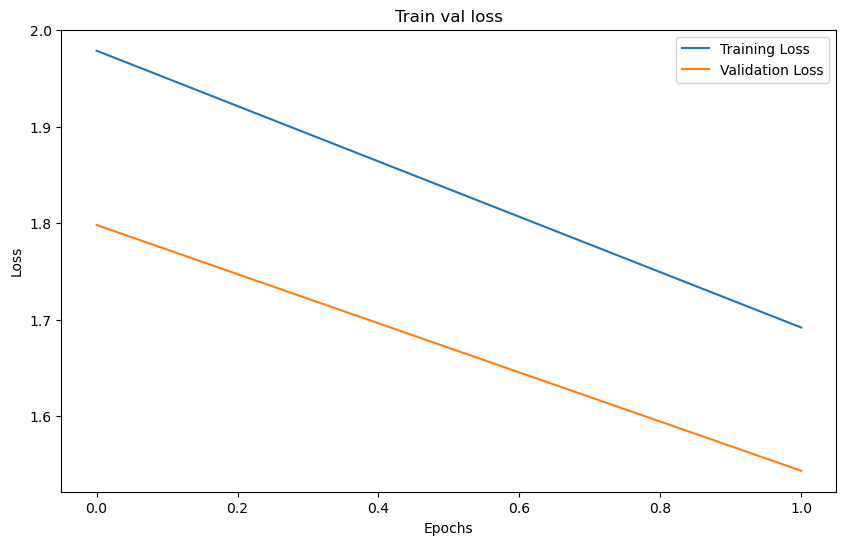

In [23]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')  
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Train val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)  # Generate predictions using the trained model on the test data

# Inverse scaling of predictions and actual values
# Combine features and predicted values, then inverse transform to get original scale
y_pred_test_inverse = scaler.inverse_transform(np.hstack((X_test.reshape(X_test.shape[0], -1), y_pred_test)))
y_test_inverse = scaler.inverse_transform(np.hstack((X_test.reshape(X_test.shape[0], -1), y_test.reshape(-1, 1))))

# Create a DataFrame for the predicted and actual sales
predictions_df = pd.DataFrame({
    'Year-Month': test_data.index,  # Use the index from the test data for the Year-Month
    'Real Sales': y_test_inverse[:, -1],  # Last column for 'Sales' values
    'Predicted Sales': y_pred_test_inverse[:, -1]  # Last column for predicted 'Sales'
})

#* ############## Convert dummy columns to categorical columns
#* ######################################################################

state_columns = [col for col in test_data.columns if 'State_' in col]  # Identify state dummy columns
sub_cat_columns = [col for col in test_data.columns if 'Sub-Category_' in col]  # Identify sub-category dummy columns

dummy_data = test_data[state_columns + sub_cat_columns]  # Extract dummy columns
decoded_data = pd.DataFrame(scaler.inverse_transform(dummy_data), columns=dummy_data.columns)  # Inverse scale the dummy data

decoded_data['State'] = decoded_data[state_columns].idxmax(axis=1).str.replace('State_', '')  # Get the original state names
decoded_data['Sub-Category'] = decoded_data[sub_cat_columns].idxmax(axis=1).str.replace('Sub-Category_', '')  # Get the original sub-category names

#* ######################################################################
#* ######################################################################

# Add 'State' and 'Sub-Category' columns to the predictions DataFrame
predictions_df = pd.concat([predictions_df, decoded_data[['State', 'Sub-Category']]], axis=1)

# 1. Group the original DataFrame df by Year-Month, State, and Sub-Category and sum sales
df_grouped = df.groupby(['Year-Month', 'State', 'Sub-Category'])['Sales'].sum().reset_index()  # Aggregate sales data

# Merge the predictionsaFr with the aggregated data
predictions_df = predictions_df.merge(df_grouped, on=['Year-Month', 'State', 'Sub-Category'], how='left', suffixes=('', '_agg'))

predictions_df.rename(columns={'Sales': 'Aggregated Sales'}, inplace=True)  # Rename the sales column for clarity


2024-09-29 21:10:55.982527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:56.147778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/55 [..............................] - ETA: 56s

2024-09-29 21:10:56.238147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 21:10:56.305317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 1s 6ms/step


In [25]:
df_grouped = df.groupby(['Year-Month', 'State'])['Sales'].sum().reset_index()  # Aggregate sales data

grouped_predictions = predictions_df.groupby(['State', 'Year-Month']).agg({
    'Real Sales': 'sum',  
    'Predicted Sales': 'sum' 
}).reset_index() 

In [26]:
# Convert 'Year-Month' to datetime format for plotting
if pd.api.types.is_period_dtype(grouped_predictions['Year-Month']):
    grouped_predictions['Year-Month'] = grouped_predictions['Year-Month'].dt.to_timestamp()
else:
    grouped_predictions['Year-Month'] = pd.to_datetime(grouped_predictions['Year-Month'], format='%Y-%m')

# Create a directory to save figures
output_dir = 'lstm_state_sales_figures'
os.makedirs(output_dir, exist_ok=True)

# Get the list of unique states
states = grouped_predictions['State'].unique()

# Define a common date range from January 2018 to December 2018
full_date_range = pd.date_range(start='2018-01-01', end='2018-12-01', freq='MS')

# Generate and save a plot for each state
for state in states:
    # Filter data for the current state
    state_data = grouped_predictions[grouped_predictions['State'] == state]

    # Set 'Year-Month' as the index
    state_data.set_index('Year-Month', inplace=True)
    
    # Reindex the state data to include all months from 2018-01 to 2018-12, filling NaNs with 0
    state_data = state_data.reindex(full_date_range, fill_value=0)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(state_data.index, state_data['Predicted Sales'], label='Sales Prediction', marker='o', color='blue')
    plt.plot(state_data.index, state_data['Real Sales'], label='Sales Actual', marker='o', color='orange')
    plt.title(f'Sales Prediction vs Actual Sales for {state} (2018)')
    plt.xlabel('Year-Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot to the specified directory
    file_path = os.path.join(output_dir, f'{state}.png')
    plt.savefig(file_path)
    plt.close()  # Close the figure to free up memory

print(f'Figures saved in the directory: {output_dir}')


Figures saved in the directory: lstm_state_sales_figures


In [27]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            66000     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 batch_normalization (Batch  (None, 1, 100)            400       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 1, 100)            400       
 chNormalization)                                       

# GROUND TRUTH & ESAMBLE

In [28]:
df_real = df.groupby(['Year-Month', 'State'])['Sales'].sum().reset_index()

In [29]:

df_real['Year-Month'] = df_real['Year-Month'].astype(str)

# Ensure 'Year-Month' is a string in both DataFrames
grouped_predictions['Year-Month'] = grouped_predictions['Year-Month'].astype(str)
prediction_and_actuals['Year-Month'] = prediction_and_actuals['Year-Month'].astype(str)

# Remove the last 3 characters from 'Year-Month'
grouped_predictions['Year-Month'] = grouped_predictions['Year-Month'].str[:-3]
prediction_and_actuals['Year-Month'] = prediction_and_actuals['Year-Month'].str[:-3]




In [30]:

# Rename columns for LSTM model
df_lstm = grouped_predictions.rename(columns={
    'Predicted Sales': 'lstm_Predicted_Sales',
})

# Rename columns for SARIMA model
df_sarima = prediction_and_actuals.rename(columns={
    'Sales_Prediction': 'sarima_Sales_Prediction',
})

# Create a list of all months in string format for 2018
months_2018 = pd.date_range(start='2018-01-01', end='2018-12-31', freq='M').strftime('%Y-%m').tolist()

# Get all unique states from the dataframes
all_states = pd.concat([df_lstm['State'], df_sarima['State'], df_real['State']]).unique()

# Create all possible combinations of states and Year-Months
state_month_combinations = pd.MultiIndex.from_product([all_states, months_2018], names=['State', 'Year-Month']).to_frame(index=False)

# Merge with real data
ground_truth = pd.merge(state_month_combinations, df_real, on=['State', 'Year-Month'], how='left')

# Merge with LSTM predictions
ground_truth = pd.merge(ground_truth, df_lstm[['State', 'Year-Month',  'lstm_Predicted_Sales']], 
                         on=['State', 'Year-Month'], how='left')




# Display the final result


In [31]:
# Merge with SARIMA data
ground_truth = pd.merge(ground_truth, df_sarima[['State', 'Year-Month', 'sarima_Sales_Prediction']], 
                         on=['State', 'Year-Month'], how='left')

# Select relevant columns for the final result
ground_truth = ground_truth[['State', 'Year-Month', 'Sales', 'lstm_Predicted_Sales', 'sarima_Sales_Prediction']]

# Calculate average between LSTM and SARIMA to create "ensemble" column
ground_truth['ensemble'] = ground_truth[['lstm_Predicted_Sales', 'sarima_Sales_Prediction']].mean(axis=1)

# fill na with 0 all the dataset ground_thrut
ground_truth = ground_truth.fillna(0)

print(ground_truth)


       State Year-Month        Sales  lstm_Predicted_Sales  \
0    Arizona    2018-01   100.922000           -547.727112   
1    Arizona    2018-02  1112.044723           -788.171997   
2    Arizona    2018-03     0.000000              0.000000   
3    Arizona    2018-04   560.896000           -674.416626   
4    Arizona    2018-05  1087.963897           -802.611206   
..       ...        ...          ...                   ...   
583  Wyoming    2018-08     0.000000              0.000000   
584  Wyoming    2018-09     0.000000              0.000000   
585  Wyoming    2018-10     0.000000              0.000000   
586  Wyoming    2018-11     0.000000              0.000000   
587  Wyoming    2018-12     0.000000              0.000000   

     sarima_Sales_Prediction    ensemble  
0                 130.853585 -208.436764  
1                2703.108032  957.468018  
2                   0.000000    0.000000  
3                1151.432516  238.507945  
4                1928.195044  562.791919

In [32]:
import numpy as np
import pandas as pd

# Calculate weighted average between LSTM and SARIMA
weight_lstm = 0.3  # LSTM weight
weight_sarima = 0.7  # SARIMA weight
ground_truth['weighted_ensemble'] = (ground_truth['lstm_Predicted_Sales'] * weight_lstm +
                                      ground_truth['sarima_Sales_Prediction'] * weight_sarima)

# Define function to calculate RMSE, MSE, and MAE
def calculate_metrics(df, prediction_col):
    # Remove rows with null values
    df = df.dropna(subset=['Sales', prediction_col])

    # Calculate RMSE
    rmse = np.sqrt(np.mean((df['Sales'] - df[prediction_col]) ** 2))
    
    # Calculate MSE
    mse = np.mean((df['Sales'] - df[prediction_col]) ** 2)

    # Calculate MAE
    mae = np.mean(np.abs(df['Sales'] - df[prediction_col]))

    return rmse, mse, mae

# Step: Calculate metrics for each state and year-month
metrics_results = []
state_metrics_results = []

# Group by both 'State' and 'Year-Month'
for (state, year_month), group in ground_truth.groupby(['State', 'Year-Month']):
    # Calculate metrics for weighted ensemble
    rmse_weighted, mse_weighted, mae_weighted = calculate_metrics(group, 'weighted_ensemble')
    
    # Calculate metrics for LSTM predictions
    rmse_lstm, mse_lstm, mae_lstm = calculate_metrics(group, 'lstm_Predicted_Sales')
    
    # Calculate metrics for SARIMA predictions
    rmse_sarima, mse_sarima, mae_sarima = calculate_metrics(group, 'sarima_Sales_Prediction')

    # Append results for Year-Month
    metrics_results.append({
        'State': state,
        'Year-Month': year_month,
        'SARIMA_Sales_Prediction': group['sarima_Sales_Prediction'].mean(),
        'LSTM_Predicted_Sales': group['lstm_Predicted_Sales'].mean(),
        'Weighted_Ensemble': group['weighted_ensemble'].mean(),
        'RMSE_Weighted_Ensemble': rmse_weighted,
        'MSE_Weighted_Ensemble': mse_weighted,
        'MAE_Weighted_Ensemble': mae_weighted,
        'RMSE_LSTM': rmse_lstm,
        'MSE_LSTM': mse_lstm,
        'MAE_LSTM': mae_lstm,
        'RMSE_SARIMA': rmse_sarima,
        'MSE_SARIMA': mse_sarima,
        'MAE_SARIMA': mae_sarima,
        'Sales': group['Sales'].mean()  # Average for each state and month
    })

    # Accumulate metrics for each state
    if state not in [entry['State'] for entry in state_metrics_results]:
        state_group = ground_truth[ground_truth['State'] == state]
        
        # Calculate metrics for the state as a whole
        rmse_weighted_state, mse_weighted_state, mae_weighted_state = calculate_metrics(state_group, 'weighted_ensemble')
        rmse_lstm_state, mse_lstm_state, mae_lstm_state = calculate_metrics(state_group, 'lstm_Predicted_Sales')
        rmse_sarima_state, mse_sarima_state, mae_sarima_state = calculate_metrics(state_group, 'sarima_Sales_Prediction')

        state_metrics_results.append({
            'State': state,
            'SARIMA_Sales_Prediction': state_group['sarima_Sales_Prediction'].mean(),
            'LSTM_Predicted_Sales': state_group['lstm_Predicted_Sales'].mean(),
            'Weighted_Ensemble': state_group['weighted_ensemble'].mean(),
            'RMSE_Weighted_Ensemble': rmse_weighted_state,
            'MSE_Weighted_Ensemble': mse_weighted_state,
            'MAE_Weighted_Ensemble': mae_weighted_state,
            'RMSE_LSTM': rmse_lstm_state,
            'MSE_LSTM': mse_lstm_state,
            'MAE_LSTM': mae_lstm_state,
            'RMSE_SARIMA': rmse_sarima_state,
            'MSE_SARIMA': mse_sarima_state,
            'MAE_SARIMA': mae_sarima_state,
            'Sales': state_group['Sales'].mean()  # Average for the state
        })

# Create DataFrames from the results
metrics_df_monthly = pd.DataFrame(metrics_results)
metrics_df_state = pd.DataFrame(state_metrics_results)

# Save the results to CSV files
metrics_df_monthly.to_csv('output/models_results_outputs_monthly.csv', index=False)
metrics_df_state.to_csv('output/models_results_outputs_state.csv', index=False)



In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Year-Month' to datetime format for plotting in ground_truth
if pd.api.types.is_period_dtype(ground_truth['Year-Month']):
    ground_truth['Year-Month'] = ground_truth['Year-Month'].dt.to_timestamp()
else:
    ground_truth['Year-Month'] = pd.to_datetime(ground_truth['Year-Month'], format='%Y-%m')

# Create a directory to save figures
output_dir = 'esamble_state_sales_figures'
os.makedirs(output_dir, exist_ok=True)

# Get the list of unique states
states = ground_truth['State'].unique()

# Define a common date range from January 2018 to December 2018
full_date_range = pd.date_range(start='2018-01-01', end='2018-12-01', freq='MS')

# Generate and save a plot for each state
for state in states:
    # Filter data for the current state
    state_data = ground_truth[ground_truth['State'] == state]

    # Set 'Year-Month' as the index
    state_data.set_index('Year-Month', inplace=True)
    
    # Reindex the state data to include all months from 2018-01 to 2018-12, filling NaNs with 0
    state_data = state_data.reindex(full_date_range, fill_value=0)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(state_data.index, state_data['weighted_ensemble'], label='Weighted Ensemble', marker='o', color='blue')
    plt.plot(state_data.index, state_data['Sales'], label='Sales Actual', marker='o', color='orange')
    plt.title(f'Sales Prediction vs Actual Sales for {state} (2018)')
    plt.xlabel('Year-Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot to the specified directory
    file_path = os.path.join(output_dir, f'{state}.png')
    plt.savefig(file_path)
    plt.close()  # Close the figure to free up memory

print(f'Figures saved in the directory: {output_dir}')


Figures saved in the directory: esamble_state_sales_figures
